In [29]:
import pandas as pds
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifierimport sklearn.inspection as skli
import seaborn as sns

In [2]:
# Read and join tables
dir = os.getcwd()

leaderboards = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\leaderboards-data.csv"), parse_dates=['date', 'verifiedDate'])
games = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\games-data.csv"), parse_dates=['releaseDate', 'createdDate'])
users = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\users-data.csv"), parse_dates=['signupDate'])
categories = pds.read_csv(os.path.join(os.getcwd(),"data\\v1\\categories-data.csv"))

data_frame = leaderboards.merge(games, left_on="gameID", right_on="ID", how="left", suffixes=('_df1', '_gme'))
data_frame = data_frame.merge(users, left_on="players", right_on="ID", how="left", suffixes=('_df2', '_usr'))
data_frame = data_frame.merge(categories, left_on="categoryID", right_on="ID", how="left", suffixes=('_df3', '_cat'))

data_frame = data_frame.drop(columns=['ID_df2', 'name_df2', 'URL', 'name_usr', 'parentGameID', 'ID_usr', 'name', 'rules', 'variablesAndValues', 'ID'])
 
# Split players rows where there are multiple players into multiple rows 
cols = list(data_frame.columns.drop('players' ))
data_frame = (data_frame
   .set_index(cols)
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)

target = data_frame['emulated']
data_frame = data_frame.drop(columns=['levelID', 'emulated'])

for col in data_frame.columns[data_frame.dtypes == 'object']:
    data_frame[col] = data_frame[col].astype('category')

In [3]:
# Print Table

pds.set_option('display.max_columns', None)
display(data_frame)
print(data_frame.dtypes)

,gameID,categoryID,date,primaryTime,place,platform,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,j1n8nj91,8249gled,2022-10-08,114.067,2,vm9vn63k,0jm4ppnj,2022-10-11 19:00:28+00:00,1971-11-01,2022-10-11 15:53:28+00:00,3,0,2018-06-05 14:39:39+00:00,NaN,204.0,per-game,1,0jm4ppnj
1,j1n8nj91,8249gled,2022-12-20,108.000,1,vm9vn63k,0jm4ppnj,2022-12-21 09:32:39+00:00,1971-11-01,2022-10-11 15:53:28+00:00,3,0,2021-11-08 20:34:20+00:00,us,36.0,per-game,1,8d4kdg58
2,ldejl7j1,w20m70zk,2023-06-18,434.000,1,NaN,j204y17x,2023-07-08 15:55:58+00:00,1975-01-01,2023-05-24 18:46:03+00:00,1,0,2023-05-20 22:30:30+00:00,us,22.0,per-game,1,xk1lp76j
3,ldejl7j1,w20m70zk,2023-05-24,610.000,2,NaN,j204y17x,2023-05-24 19:22:27+00:00,1975-01-01,2023-05-24 18:46:03+00:00,1,0,2023-05-17 04:56:49+00:00,us,1.0,per-game,1,j204y17x
4,9d389y91,vdopjgy2,2022-08-19,25.000,1,v06ddw64,8vk4w7vj,2022-08-23 07:09:21+00:00,1976-01-01,2022-08-23 03:09:59+00:00,1,0,2021-04-27 03:29:39+00:00,jp,109.0,per-game,1,8vk4w7vj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,268wwry6,wkpgwqvk,2023-05-27,521.852,1,8gej2n93,8wknpmq8,2023-06-06 19:14:13+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,pj0o619j
1909099,268wwry6,wkpgwqvk,2023-01-06,1630.129,20,8gej2n93,8wknpmq8,2023-01-08 21:37:36+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,xzlv7de8
1909100,268wwry6,wkpgwqvk,2023-01-06,1630.129,20,8gej2n93,8wknpmq8,2023-01-08 21:37:36+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,8lp7wo2j
1909101,268wwry6,wkpgwqvk,2022-02-16,940.356,0,8gej2n93,8wknpmq8,2022-02-16 15:01:28+00:00,2023-11-07,2021-06-26 20:35:23+00:00,2,0,NaT,NaN,NaN,per-game,2,xkm6oe7j


gameID                      category
categoryID                  category
date                  datetime64[ns]
primaryTime                  float64
place                          int64
platform                    category
examiner                    category
verifiedDate     datetime64[ns, UTC]
releaseDate           datetime64[ns]
createdDate      datetime64[ns, UTC]
numCategories                  int64
numLevels                      int64
signupDate       datetime64[ns, UTC]
location                    category
numRuns                      float64
type                        category
numPlayers                     int64
players                     category
dtype: object


In [4]:
# Preprocessing

def replaceNaNsWithMostFrequent(value):
    return value.fillna(value.mode()[0])

def replaceNaNsWithMean(value):
    return value.fillna(value.mean())

def mapValuesToIntegers(value):
    return value.cat.codes

def convertToUNIXTimestamp(date):
    return (date.fillna("1970-01-01").astype('int64') // (10**9)).replace(0, np.NaN)

data_frame[['date', 
            'verifiedDate', 
            'releaseDate', 
            'createdDate', 
            'signupDate']] = data_frame[['date', 
                                         'verifiedDate', 
                                         'releaseDate', 
                                         'createdDate', 
                                         'signupDate']].apply(convertToUNIXTimestamp)
data_frame[['date', 
            'verifiedDate', 
            'releaseDate', 
            'createdDate', 
            'signupDate',
            'numRuns']] = data_frame[['date', 
                                         'verifiedDate', 
                                         'releaseDate', 
                                         'createdDate', 
                                         'signupDate',
                                         'numRuns']].apply(replaceNaNsWithMean)

for col in data_frame.columns[data_frame.dtypes == 'category']:
    data_frame[[col]] = data_frame[[col]].apply(replaceNaNsWithMostFrequent)
    data_frame[[col]] = data_frame[[col]].apply(mapValuesToIntegers)

display(data_frame)
print(data_frame.dtypes)

,gameID,categoryID,date,primaryTime,place,platform,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,13979,18905,1.665187e+09,114.067,2,161,115,1.665515e+09,57801600,1.665504e+09,3,0,1.528210e+09,239,204.00000,0,1,557
1,13979,18905,1.671494e+09,108.000,1,161,115,1.671615e+09,57801600,1.665504e+09,3,0,1.636404e+09,239,36.00000,0,1,59417
2,19567,70218,1.687046e+09,434.000,1,44,15197,1.688832e+09,157766400,1.684954e+09,1,0,1.684622e+09,239,22.00000,0,1,340391
3,19567,70218,1.684886e+09,610.000,2,44,15197,1.684956e+09,157766400,1.684954e+09,1,0,1.684299e+09,239,1.00000,0,1,179902
4,9363,66635,1.660867e+09,25.000,1,151,11455,1.661239e+09,189302400,1.661224e+09,1,0,1.619494e+09,122,109.00000,0,1,139352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,1640,83345,1.685146e+09,521.852,1,44,11994,1.686079e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,288823
1909099,1640,83345,1.672963e+09,1630.129,20,44,11994,1.673214e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,377700
1909100,1640,83345,1.672963e+09,1630.129,20,44,11994,1.673214e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,102415
1909101,1640,83345,1.644970e+09,940.356,0,44,11994,1.645024e+09,1699315200,1.624740e+09,2,0,1.569096e+09,239,510.22873,0,2,347439


gameID             int32
categoryID         int32
date             float64
primaryTime      float64
place              int64
platform           int16
examiner           int32
verifiedDate     float64
releaseDate        int64
createdDate      float64
numCategories      int64
numLevels          int64
signupDate       float64
location           int16
numRuns          float64
type                int8
numPlayers         int64
players            int32
dtype: object


In [5]:
# Normalization

minmax = data_frame.copy(deep=True)

for col in data_frame.columns[data_frame.dtypes != 'bool']:
    minimum = data_frame[col].min()
    minmax[col] = (data_frame[col] - minimum) / (data_frame[col].max() - minimum)

display(data_frame)
print(data_frame.isnull().sum())
display(minmax)
print(minmax.isnull().sum())

,gameID,categoryID,date,primaryTime,place,platform,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,-0.489307,-1.130003,0.756997,-0.084761,-0.241484,2.188311,-1.665422,0.762396,-4.613911,1.704493,-0.654690,-0.32503,-5.978809e-01,0.832991,-2.180691e-01,-0.986336,-0.320399,-1.553024
1,-0.489307,-1.130003,0.853812,-0.085053,-0.244073,2.188311,-1.665422,0.867104,-4.613911,1.704493,-0.654690,-0.32503,9.842549e-01,0.832991,-3.377038e-01,-0.986336,-0.320399,-1.073592
2,0.058287,0.499236,1.092533,-0.069387,-0.244073,-0.577306,-0.131093,1.162618,-4.253076,1.959457,-0.831221,-0.32503,1.689355e+00,0.832991,-3.476734e-01,-0.986336,-0.320399,1.215021
3,0.058287,0.499236,1.059377,-0.060929,-0.241484,-0.577306,-0.131093,1.096095,-4.253076,1.959457,-0.831221,-0.32503,1.684640e+00,0.832991,-3.626277e-01,-0.986336,-0.320399,-0.092208
4,-0.941649,0.385472,0.690686,-0.089041,-0.244073,1.951934,-0.511776,0.688996,-4.139244,1.648396,-0.831221,-0.32503,7.369854e-01,-0.554089,-2.857197e-01,-0.986336,-0.320399,-0.422499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,-1.698461,0.916031,1.063356,-0.065165,-0.244073,-0.577306,-0.456942,1.115365,1.311321,1.170142,-0.742955,-0.32503,-3.486425e-15,0.832991,-8.095773e-17,-0.986336,0.205835,0.794985
1909099,-1.698461,0.916031,0.876358,-0.011908,-0.194896,-0.577306,-0.456942,0.894545,1.311321,1.170142,-0.742955,-0.32503,-3.486425e-15,0.832991,-8.095773e-17,-0.986336,0.205835,1.518913
1909100,-1.698461,0.916031,0.876358,-0.011908,-0.194896,-0.577306,-0.456942,0.894545,1.311321,1.170142,-0.742955,-0.32503,-3.486425e-15,0.832991,-8.095773e-17,-0.986336,0.205835,-0.723361
1909101,-1.698461,0.916031,0.446659,-0.045054,-0.246661,-0.577306,-0.456942,0.410677,1.311321,1.170142,-0.742955,-0.32503,-3.486425e-15,0.832991,-8.095773e-17,-0.986336,0.205835,1.272429


gameID           0
categoryID       0
date             0
primaryTime      0
place            0
platform         0
examiner         0
verifiedDate     0
releaseDate      0
createdDate      0
numCategories    0
numLevels        0
signupDate       0
location         0
numRuns          0
type             0
numPlayers       0
players          0
dtype: int64


,gameID,categoryID,date,primaryTime,place,platform,examiner,verifiedDate,releaseDate,createdDate,numCategories,numLevels,signupDate,location,numRuns,type,numPlayers,players
0,0.386128,0.171887,0.978781,0.000032,0.000327,0.884615,0.003438,0.873229,0.000000,0.881013,0.010811,0.0,0.452109,0.929961,0.020400,0.0,0.000000,0.001430
1,0.386128,0.171887,0.982634,0.000030,0.000164,0.884615,0.003438,0.895609,0.000000,0.881013,0.010811,0.0,0.797511,0.929961,0.003600,0.0,0.000000,0.152579
2,0.540480,0.638433,0.992135,0.000121,0.000164,0.241758,0.454374,0.958770,0.060898,0.950076,0.000000,0.0,0.951444,0.929961,0.002200,0.0,0.000000,0.874102
3,0.540480,0.638433,0.990816,0.000169,0.000327,0.241758,0.454374,0.944552,0.060898,0.950076,0.000000,0.0,0.950414,0.929961,0.000100,0.0,0.000000,0.461977
4,0.258625,0.605855,0.976141,0.000007,0.000164,0.829670,0.342492,0.857541,0.080109,0.865819,0.000000,0.0,0.743528,0.474708,0.010900,0.0,0.000000,0.357847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909098,0.045300,0.757785,0.990974,0.000145,0.000164,0.241758,0.358608,0.948671,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.741679
1909099,0.045300,0.757785,0.983531,0.000453,0.003270,0.241758,0.358608,0.901474,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.969909
1909100,0.045300,0.757785,0.983531,0.000453,0.003270,0.241758,0.358608,0.901474,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.262995
1909101,0.045300,0.757785,0.966429,0.000261,0.000000,0.241758,0.358608,0.798054,1.000000,0.736273,0.005405,0.0,0.582634,0.929961,0.051023,0.0,0.052632,0.892201


gameID           0
categoryID       0
date             0
primaryTime      0
place            0
platform         0
examiner         0
verifiedDate     0
releaseDate      0
createdDate      0
numCategories    0
numLevels        0
signupDate       0
location         0
numRuns          0
type             0
numPlayers       0
players          0
dtype: int64


In [ ]:
# Test-Train Split + Downsampling
rdm_seed = 404

minmax_majority = minmax[minmax['emulated'] == False]
minmax_minority = minmax[minmax['emulated'] == True]

mm_downsampled = resample(minmax_majority, 
                                 replace=False,    
                                 n_samples=len(minmax_minority),  
                                 random_state=rdm_seed) 

minmax = pds.concat([mm_downsampled, minmax_minority])
 
# Display new class counts
print(np.unique(minmax['emulated'], return_counts=True))

target = minmax['emulated']
minmax = minmax.drop(columns=['runID', 'emulated'])

minmax_train, minmax_test, mm_target_train, mm_target_test  = train_test_split(minmax, target,test_size = 0.33, random_state = rdm_seed, shuffle = True)
display(minmax_train)
display(minmax_test)
display(mm_target_train)
display(mm_target_test)

In [ ]:
# KNN
k = 5
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(minmax_train, mm_target_train)
target_pred = knn.predict(minmax_test)

In [ ]:
# KNN Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model with k = {k}: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [ ]:
# Multinomial Naive Bayes

MNNB = MultinomialNB()
MNNB.fit(minmax_train, mm_target_train)
target_pred = MNNB.predict(minmax_test)

In [ ]:
# Multinomial NB Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [ ]:
# Random Forest

randomForest = RandomForestClassifier(n_estimators=200, random_state=rdm_seed, class_weight='balanced')
randomForest.fit(minmax_train,mm_target_train)
target_pred = randomForest.predict(minmax_test)

In [ ]:
# Random Forest Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [ ]:
# Logistic Regression

logReg = LogisticRegression(random_state=rdm_seed, class_weight='balanced')
logReg.fit(minmax_train, mm_target_train)
target_pred = logReg.predict(minmax_test)

In [ ]:
# Logistic Regression Post-Run Statistics

accuracy = accuracy_score(mm_target_test,target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [ ]:
# Decision Tree

dTree = DecisionTreeClassifier(random_state=rdm_seed, class_weight='balanced')
dTree.fit(minmax_train,mm_target_train)
target_pred = dTree.predict(minmax_test)

In [ ]:
# Decision Tree Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [ ]:
# AdaBoost

adaBoost = AdaBoostClassifier(algorithm='SAMME', random_state=rdm_seed)
adaBoost.fit(minmax_train,mm_target_train)
target_pred = adaBoost.predict(minmax_test)

In [ ]:
# AdaBoost Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [ ]:
# Multi-Layered Perceptron

MLP = MLPClassifier(random_state=rdm_seed, max_iter=1000)
MLP.fit(minmax_train, mm_target_train)
target_pred = MLP.predict(minmax_test)

In [ ]:
# Multi-Layered Perceptron Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) * 100
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

Accuracy of model: 0.9435019460193903%

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.98      0.97    573750
        True       0.73      0.58      0.65     56254

    accuracy                           0.94    630004
   macro avg       0.84      0.78      0.81    630004
weighted avg       0.94      0.94      0.94    630004



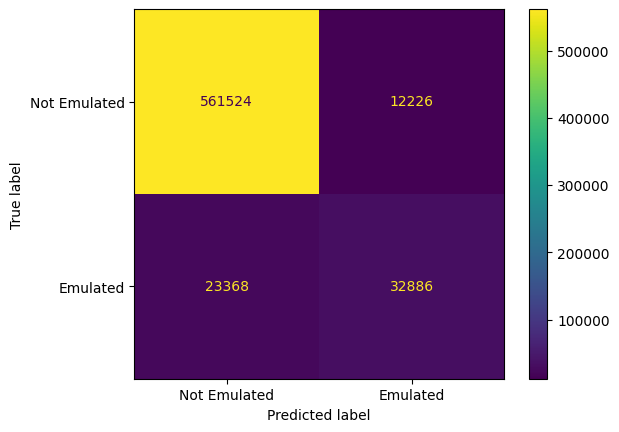

In [21]:
# Decision Tree Post-Run Statistics

accuracy = accuracy_score(mm_target_test, target_pred) 
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()
plt.show()

In [22]:
#Bagging Classifier

bgc=BaggingClassifier()
bgc.fit(minmax_train, mm_target_train)  
target_pred = bgc.predict(minmax_test)

Accuracy of model: 0.975830312188494%

Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.99    573750
        True       0.89      0.83      0.86     56254

    accuracy                           0.98    630004
   macro avg       0.94      0.91      0.92    630004
weighted avg       0.98      0.98      0.98    630004



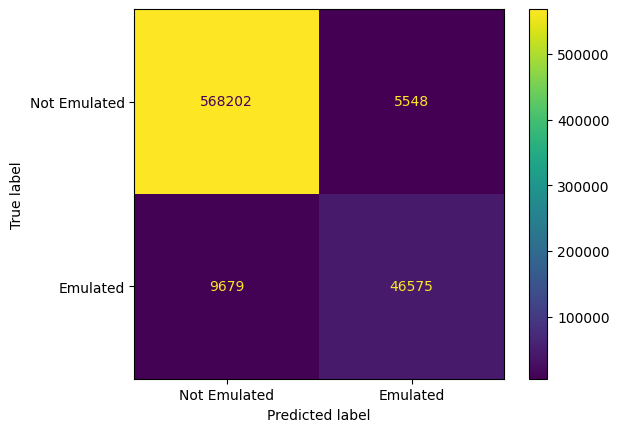

In [23]:
#Bagging Classifier Statistics

accuracy = accuracy_score(mm_target_test,target_pred) 
conMatrix = confusion_matrix(mm_target_test, target_pred)

print(f'Accuracy of model: {accuracy}%\n')
print(f'Classification Report:\n {classification_report(mm_target_test, target_pred)}')
ConfusionMatrixDisplay(conMatrix, display_labels=["Not Emulated", "Emulated"],).plot()

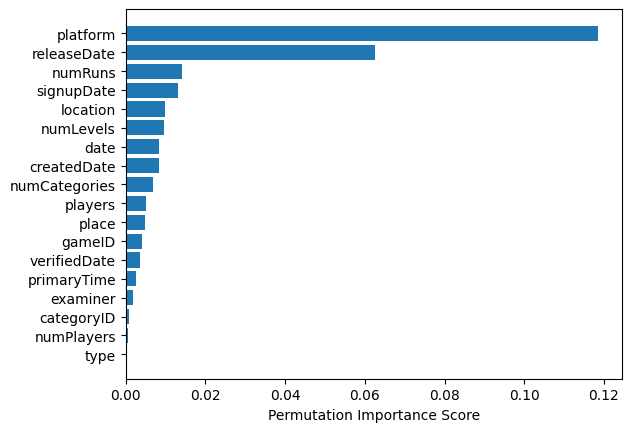

In [34]:
importance = skli.permutation_importance(bgc, minmax_test, mm_target_test, n_repeats=30, random_state=rdm_seed)
sorted_importances = importance.importances_mean.argsort()
plt.barh(minmax_train.columns[sorted_importances], importance.importances_mean[sorted_importances])
plt.xlabel("Permutation Importance Score")
plt.show()

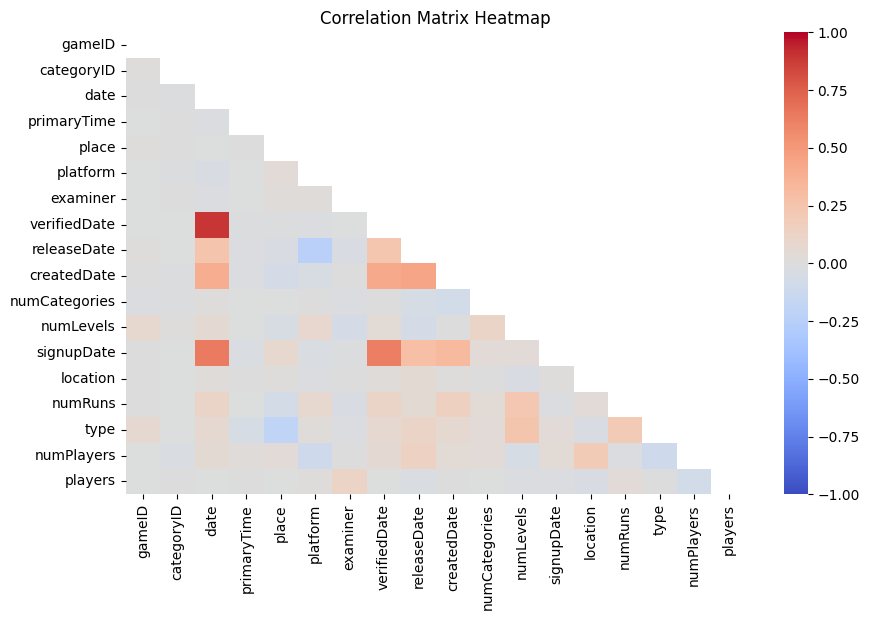

In [35]:
corr_matrix = data_frame.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
plt.figure(figsize=(10, 6)) 
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
heatmap.set_title('Correlation Matrix Heatmap')
plt.show()